In [ ]:
import torch
import torchvision
import torch.nn as nn
import os
import time
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from zipfile import ZipFile


import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_file_path = '/content/drive/MyDrive/Dataset.zip'
extract_folder = '/content/extracted_data'

with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

In [ ]:
class DenseNetClassifier(nn.Module):
    def __init__(self):
        super(DenseNetClassifier, self).__init__()
        # Define your DenseNet architecture here
        # Example using a pre-trained DenseNet model
        self.densenet = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)

        # Modify the classifier for 5 classes
        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_ftrs, 5)

    def forward(self, x):
        x = self.densenet(x)
        return x

model = DenseNetClassifier()
print(model)

DenseNetClassifier(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, 

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


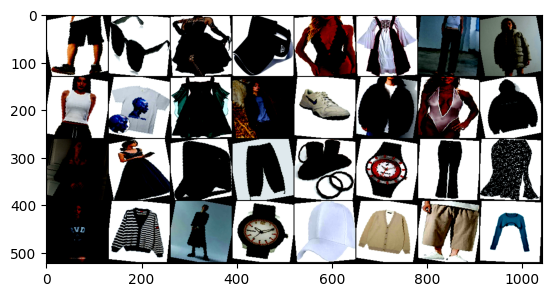

tensor([2, 0, 4, 0, 0, 4, 2, 3, 1, 1, 4, 3, 0, 3, 0, 1, 1, 4, 0, 2, 0, 0, 2, 2,
        1, 3, 4, 0, 0, 3, 2, 3])


In [ ]:
class MyDataset(Dataset):
    def __init__(self, img_path):
        super(MyDataset, self).__init__()
        self.root = img_path
        self.ncloth_root = self.root + '/extracted_data' + '//' + 'NoCloth'
        self.top_root = self.root + '/extracted_data' + '//' + 'Top'
        self.bot_root = self.root + '/extracted_data' + '//' + 'Bottom'
        self.out_root = self.root + '/extracted_data' + '//' + 'OutWear'
        self.dre_root = self.root + '/extracted_data' + '//' + 'Dress'

        tfiles = os.listdir(self.top_root)
        bfiles = os.listdir(self.bot_root)
        ofiles = os.listdir(self.out_root)
        dfiles = os.listdir(self.dre_root)
        ncfiles = os.listdir(self.ncloth_root)
        imgs = []
        labels = []
        for file in tfiles:
            imgs.append(os.path.join(self.top_root, file))
            labels.append(1)
        for file in bfiles:
            imgs.append(os.path.join(self.bot_root, file))
            labels.append(2)
        for file in ofiles:
            imgs.append(os.path.join(self.out_root, file))
            labels.append(3)
        for file in dfiles:
            imgs.append(os.path.join(self.dre_root, file))
            labels.append(4)
        for file in ncfiles:
            imgs.append(os.path.join(self.ncloth_root, file))
            labels.append(0)

        self.img = imgs
        self.label = labels
        self.transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.RandomRotation(12),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.6536668, 0.6384577, 0.634824], std=[0.3062009 , 0.30868983, 0.30787063])
        ])


    def __len__(self):
        return len(self.img)

    def __getitem__(self, item):
        img = self.img[item]
        label = self.label[item]
        img = Image.open(img).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)
        label = torch.tensor(label)
        #label = label.reshape(label.shape[0],1)
        return img, label

image_path = '/content'

dataset = MyDataset(image_path)

train_size = int(0.9 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])


data_loader = DataLoader(dataset, batch_size=32, shuffle=True, pin_memory=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
val_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, pin_memory=True)

for X in train_loader:
    images, labels = X

    img = torchvision.utils.make_grid(images).numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()
    print(labels)
    break

In [ ]:
n_pic = len(dataset)
def compute_mean_std(DataLoader):

    # Initialize the mean and std
    mean = 0.
    std = 0.
    loader = DataLoader
    # Iterate over the dataset
    for images, _ in loader:
      images = images.to(device)
      batch_samples = images.size(0) # Get the batch size
      images = images.view(batch_samples, images.size(1), -1)
      mean += images.mean(2).sum(0)
      std += images.std(2).sum(0)

    # Compute the mean and std for the whole dataset
    mean /= n_pic
    std /= n_pic

    return mean.cpu().numpy(), std.cpu().numpy()
print(compute_mean_std(data_loader))

(array([0.00127403, 0.00134192, 0.00135626], dtype=float32), array([0.9981802, 0.9984284, 0.998234 ], dtype=float32))


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.cuda()
initial_learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 20
big_epoch_acc = 0

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    start_time = time.time()

    for imgs, labels in train_loader:
      imgs, labels = imgs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(imgs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()

    #Evaluation
    model.eval()
    with torch.no_grad():
      for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
    epoch_acc = 100 * correct_predictions / total_predictions
    epoch_time = time.time() - start_time
    if(epoch_acc > big_epoch_acc):
      big_epoch_acc = epoch_acc
    if(epoch > 5 and epoch_acc >= big_epoch_acc):
      torch.save(model.state_dict(), '/content/drive/MyDrive/32HigtLRLastTopClassifier.pth')
    print(f"Loss:{epoch_loss:.4f}, Time:{epoch_time:.2f}， Acc:{epoch_acc:.2f}")

Loss:101.7401, Time:35.64， Acc:88.21
Loss:41.0200, Time:36.35， Acc:90.99
Loss:27.0568, Time:35.82， Acc:91.85
Loss:17.0997, Time:35.95， Acc:91.16
Loss:13.9813, Time:35.96， Acc:91.85
Loss:10.7704, Time:36.02， Acc:90.99
Loss:9.9561, Time:35.83， Acc:89.77
Loss:10.7002, Time:35.85， Acc:91.51
Loss:7.5659, Time:35.64， Acc:92.55
Loss:5.7175, Time:35.54， Acc:91.51
Loss:4.6497, Time:35.33， Acc:92.89
Loss:5.2817, Time:35.08， Acc:92.20
Loss:3.6772, Time:35.33， Acc:91.16
Loss:6.2289, Time:35.18， Acc:90.99
Loss:3.9116, Time:35.64， Acc:92.55
Loss:3.4526, Time:35.58， Acc:92.89
Loss:6.4927, Time:35.59， Acc:91.85
Loss:7.3652, Time:35.65， Acc:90.99
Loss:4.5697, Time:35.74， Acc:91.68
Loss:3.7650, Time:35.72， Acc:91.51


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/32HigtLRLastFianlClassifier.pth')